# <i class="fas fa-circle exercise"></i> Preprocessing and cleaning
<span class="badge badge-pill badge-warning">exercise</span>
<span class="badge badge-pill badge-dark">notebook</span>

The purpose of this exercise is to implement a procedure for extracting barcodes from images. This may be used as a pre-processing step for a barcode reader. You will work with binary images, BLOB detection, and BLOB classification.

```{note}
The real notebook (the one in the materials repository or the one you can download from this page) contains some extra utility code that has been hidden here for brevity. The code is fully commented and we recommend you read it whenever you are in doubt about what is happening.
```

In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

from glob import glob
import os

In [ ]:
def create_barcode_image(frame, M, size=(1280, 960)):
    """Transform frame such that the barcode lines appear parallel to either the horizontal or vertical axes.

    Args:
        frame: Input image to be transformed.
        M: Homographic transformation.
        size: Size of the resulting image. Defaults to (1280, 960).

    Returns:
        The transformed image.
    """
    return np.zeros((size[1], size[0])) # Replace this when solving the exercise.

def show_contours(preview, barcodes):
    """Draw contours in preview.

    Args:
        preview: Preview image (3 channels).
        contours: Vector of vector of points.
        contour_scores: Vector of floats.
    """
    cv.polylines(preview, barcodes, True, (255, 0, 0), thickness=3)
    plt.imshow(preview)


def draw_barcode_preview(preview, barcode_img):
    """Draw the barcode as a small window in the corner of the preview image.

    Args:
        preview: Preview image (3 channels).
        barcode_img: Barcode image (1 channel).
    """
    b_small = cv.resize(barcode_img, (320, 240))
    b_small = cv.cvtColor(b_small, cv.COLOR_GRAY2BGR)
    cv.putText(
        b_small, "barcode img", (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255)
    )

    preview[:240, preview.shape[1] - 320 :, :] = b_small


def draw_threshold_preview(preview, thresh_img):
    """Draw the threshold image as a small window in the corner of the preview image.

    Args:
        preview: Preview image (3 channels).
        thresh_img: Threshold image (1 channel).
    """
    t_small = cv.resize(thresh_img, (320, 240))
    t_small = cv.cvtColor(t_small, cv.COLOR_GRAY2BGR)
    cv.putText(
        t_small, "binary img", (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255)
    )

    preview[:240, :320, :] = t_small

### Basic setup
Our goal is to isolate the barcode and remove the perspective distortion caused by it not being parallel to the camera plane. This is done by using blob detection as explored during the lecture. The detected barcode is then transformed to remove the perspective distortion.

This process can be broken down into the following steps:

1. Use thresholding to form BLOBS around barcode boxes.
2. Find contours in the resulting binary image.
3. Evaluate each contour according to some metric.
4. Select one or more contour candidates to process further.
5. Try to approximate contour as a rectangle.
6. Use rectangle corners to create a homography.
7. Transform image such that barcode lines is rectified and the lines are vertical.

## Data overview
The following example loads a bunch of sample images for you to work with in the `images` list. Check out some of the other images by changing the list index.

```{tip}
Try out different images when implementing the exercise. You might want to find one of the easy or medium images for the initial version and then adapt it to work on the harder images. The `hardest1` image is there as an optional challenge if you want to make a more sophisicated solution - it doesn't work with our reference implementation.
```

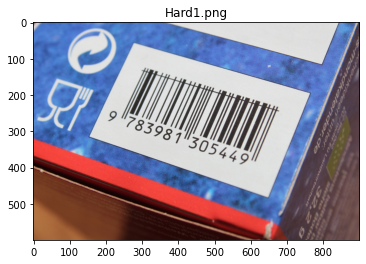

In [11]:
pattern = '../inputs/barcodes/*'
paths = list(glob(pattern))

# Load images and convert to RGB color space
names = [os.path.basename(p) for p in paths]
images = [cv.imread(path, cv.IMREAD_COLOR) for path in paths]
images = [cv.cvtColor(img, cv.COLOR_BGR2RGB) for img in images]

# Create gray-scale images for later
gray = [cv.cvtColor(img, cv.COLOR_RGB2GRAY) for img in images]

# Show example output
idx = 4
plt.imshow(images[idx])
plt.title(names[idx].capitalize());

## Image thresholding

In order to find contours, we first have to create a binary image from which these can be found. Since our goal is to isolate the white barcode box, a regular binary threshold should suffice.

- In the `image_threshold` function below, use [cv.threshold]() to create a binary image from the input `img`. Make sure you use `cv.THRESH_BINARY + cv.THRESH_OTSU` for the `type` parameter. This makes intensities above the threshold white in the output and uses _Otsu's_ method for determining this threshold. This also means that the `threshold` parameter will be ignorred.
- Check the resulting output for different images.

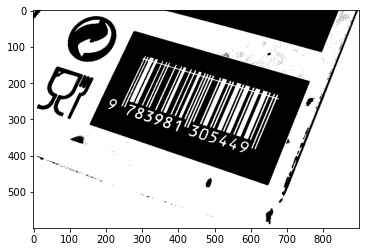

In [ ]:
# Select image
img = gray[4]

# Replace this with your implementation

#threshold = np.zeros(img.shape[:2], dtype=np.uint8) # Placeholder - replace when solving the exercise
n,thresh1 = cv.threshold(img,0,255,cv.THRESH_BINARY_INV+ cv.THRESH_OTSU)
# Show the result
plt.imshow(thresh1, cmap='gray')

### Morphology
In the following steps you will use morphological operators to remove smaller artifacts caused by the threshold methods. You may consider this as data cleaning. Change the following in the code-cell above:

- Create a kernel for the morphological operation using [cv.getStructuringElement](). Create an ellipse shape of size (5, 5).
- Apply an open operation to the binary image using the kernel you just created using [cv.morphologyEx]().
- Experiment with different kernel sizes, types, and add multiple different operations. Observe the changes to the preview image.

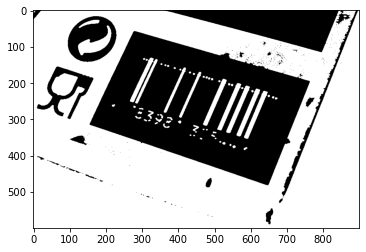

In [ ]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
opening = cv.morphologyEx(thresh1, cv.MORPH_OPEN, kernel)
plt.imshow(opening, cmap='gray')




## Contour detection
The barcode should now be reasonably well separated from the background. The next step is to use blob detection to find regions of connected pixels.

- Find contours using [cv.findContours]() using `cv.RETR_LIST` and `cv.CHAIN_APPROX_NONE` for the `mode` and `method` parameters. Insert this into the `find_barcode` function after the `# (2)` comment and remove the placeholder contours variable. Note that two values are returned, the first of which are our contours.

In [ ]:
# Replace this code
contours, _= cv.findContours(thresh1, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
print(contours)

(array([[[492, 568]],

       [[493, 567]],

       [[494, 567]],

       [[495, 568]],

       [[494, 569]],

       [[493, 569]]], dtype=int32), array([[[489, 567]],

       [[490, 566]],

       [[491, 567]],

       [[490, 568]]], dtype=int32), array([[[479, 564]],

       [[480, 563]],

       [[481, 563]],

       [[482, 563]],

       [[483, 564]],

       [[482, 565]],

       [[481, 565]],

       [[480, 565]]], dtype=int32), array([[[453, 556]],

       [[454, 555]],

       [[455, 556]],

       [[454, 557]]], dtype=int32), array([[[654, 546]],

       [[655, 545]],

       [[656, 545]],

       [[657, 545]],

       [[658, 545]],

       [[659, 546]],

       [[659, 547]],

       [[659, 548]],

       [[660, 549]],

       [[660, 550]],

       [[660, 551]],

       [[661, 552]],

       [[661, 553]],

       [[661, 554]],

       [[661, 555]],

       [[661, 556]],

       [[661, 557]],

       [[661, 558]],

       [[660, 559]],

       [[660, 560]],

       [[660, 561]]

### BLOB features and classification
The next step is to classify each BLOB as either a **barcode** or **not a barcode**. This can be done by computing and comparing BLOB features.

A simple but suitable method is to assume that barcode BLOBs are rectangular. To determine "rectangularedness", we use two OpenCV functions. The first, [cv.contourArea(c)](https://docs.opencv.org/4.5.1/d3/dc0/group__imgproc__shape.html#ga2c759ed9f497d4a618048a2f56dc97f1) finds the actual pixel-area of a contour. The second, [cv.minAreaRect()](https://docs.opencv.org/4.5.1/d3/dc0/group__imgproc__shape.html#ga3d476a3417130ae5154aea421ca7ead9) fits a rotating rectangle to the contour. We then use the following formula to determine a ratio

$$
    r = \frac{\text{true contour area}}{\text{rotated rectangle area}}.
$$

This number will always be between $0$ and $1$ because the rotated rectangle produced always encompasses all white pixels in the contour.

- Implement the ratio calculation in the `contour_ratio` function.
- Use `cv.minAreaRect` and `cv.contourArea` to calculate the ratio in the `contour_ratio` function and return the result.

```{tip}
The rectangle returned from `cv.minAreaRect` can be destructured as follows: `center, axes, angle = cv.minAreaRect(contour)`. This is not clear from the C++ docs.
```

This metric can be used to classify BLOBS as being either a barcode or not by testing the value against a threshold. Do the following:

- Implement the classification in `classify_contours` function. Use the `threshold` argument to determine which contours are pupils.
- Classify the image contours and save the result in a list.
- Use the utility function `show_contours` (code shown in the cell below) to draw the possitively classified contours.


```{note}
This scoring function is similar to the loss functions you know from machine learning. As is the concept of classification.

- Could you use machine learning for classifying BLOBS for this problem? 
- If yes, how would you set it up (don't think about the ML algorithm but what the data and labels would be).
- If no, why not? How is this different from, e.g. classifying bird species?

```

In [ ]:
def contour_ratio(c):
    """Calculate the score of a given contour. Higher values are better.

    Args:
        c: Contour (list of points).
        shape: (width, height) tuple.

    Returns:
        Score as a float value.
    """
    contour_area = cv.contourArea(c)
    rotated_rectangle_area = cv.minAreaRect(c)[1][0] * cv.minAreaRect(c)[1][1]
    #(center(x, y), (width, height), angle of rotation) = cv2.minAreaRect(points)
    if rotated_rectangle_area == 0:
        return 0
    else:
        return contour_area / rotated_rectangle_area


def classify_contours(contours, threshold):
    # Your solution here
    #if the contour ratio is greater than the set threshold then place the 
    #contour in a list and return the list
    classified_contours = []
    for contour in contours:
        if contour_ratio(contour) >= threshold:
            classified_contours.append(contour)
        
    return classified_contours

# Here we select the contour with the highest score.
barcodes = classify_contours(contours, threshold=0.9)
print(contour_ratio(contours[1]))

1.000000202815967


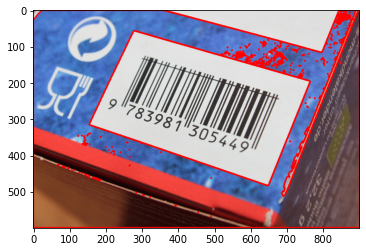

In [ ]:
preview = images[idx].copy()
show_contours(preview, barcodes)

## Rectangle approximation and transformation

The final step of preprocessing is to cut out the barcode from the image and transform it to a plain rectangular image which only contains the barcode. A barcode reader would then be able to read any code using the same base method.

First, we approximate a four-sided polygon for the BLOB. The cell below already contains the implementation. Because the BLOB is may be distorted due to the effect of perspective, we can't use the `minAreaRect` function directly. Instead, to find the four corners, we use the function [cv.approxPolyDP](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga0012a5fdaea70b8a9970165d98722b4c) to approximate the BLOB shape as a polygon. By varying the precision parameter continuously, the method hopefully yields a four-sided polygon at some point. An exception is raised if this is not the case.

- Check that the code below works and returns

In [ ]:
def find_contour_corners(c):
    """Approximate contour as a rectangle and extract the corner coordinates.

    Args:
        c: Contour.

    Raises:
        Exception: If a rectangle (four point approximation) could not be found.

    Returns:
        A list of four points.
    """
    elipson = 0.01 * cv.arcLength(c, True)
    approximations = cv.approxPolyDP(c, elipson, True)
    if len(approximations) < 4:
        raise Exception("A rectangle approximation could not be found")
    
    else:
        return approximations

ValueError: cannot reshape array of size 12 into shape (4,2)

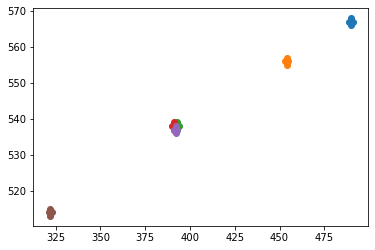

In [ ]:
boxes = []
for b in barcodes:
    # Find corners
    box = find_contour_corners(b)
    boxes.append(box)

    # Plot result
    plt.scatter(*box.reshape(4, 2).T)

Finally, we need to perform a perspective transformation. This is very similar to the affine transformation you made in an earlier exercise but uses four corresponding sets of points instead of three. This kind of transformation is called a *homography* and can transform between two planes under perspective distortion. This means we can map the flat barcode to a flat image where the barcode lines should be vertical.

```{tip}
Homographies are not part of the curriculum but they are extremely commonly used when working with images. 
```

The code is once again provided for you below. The `get_homography` function body is similar to the code you wrote to infer an affine transformation earlier. The only difference is the addition of an extra pair of points and the use of the `findHomography` function.

In [ ]:
def get_homography(corners, size=(1280, 960)):
    """Calculate homography between corners and standardised flat image.

    Args:
        corners: Image corners.
        size: Size of rectangle in result.

    Returns:
        Homography matrix.
    """
    comp = np.array([[0, 0], [0, size[1]], [size[0], size[1]], [size[0], 0]])
    M, _ = cv.findHomography(corners, comp)
    return M
    
for box in boxes:
    M = get_homography(box)
    bc = create_barcode_image(images[idx], M)
    plt.imshow(bc)

## Evaluation

That should be it. Hopefully everything now just works! However, it is definitely more likely that something doesn't quite work yet or at least doesn't work ideally. Our own solution is not particularly robust, but it does work for certain books as long as you hold them at appropriate angles - it might be necessary to twist and turn them a bit.

This is fine - the purpose of this exercise is to learn about binary images and BLOBS and give you some intuition for how to work with it. Therefore, we have also added some questions that are designed to let you think a bit deeper about the concepts used here. We encourage discussions and writing notes based on these.

- List the most obvious areas of improvement for this applicaiton. You don't have to know the solution - just point to what the weak spots are and why. Using live capture (if possible) might make this easier to test.
- Try to think of other BLOB features that might be useful for ranking barcode candidates.
- Have you noticed that the homography doesn't always pick the right direction for the barcode? Why is this and what can be done about it?
- If you haven't already, consider alternative approaches to this problem that still use some form of BLOB detection and processing.